In [1]:
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
print('check：libs well prepared')

check：libs well prepared


### 下載數據解壓縮

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  if not os.path.exists(filename):
    print('download...')
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print('exception %s' % statinfo.st_size)
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [3]:
def read_data(filename):
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


In [4]:
words

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against',
 'early',
 'working',
 'class',
 'radicals',
 'including',
 'the',
 'diggers',
 'of',
 'the',
 'english',
 'revolution',
 'and',
 'the',
 'sans',
 'culottes',
 'of',
 'the',
 'french',
 'revolution',
 'whilst',
 'the',
 'term',
 'is',
 'still',
 'used',
 'in',
 'a',
 'pejorative',
 'way',
 'to',
 'describe',
 'any',
 'act',
 'that',
 'used',
 'violent',
 'means',
 'to',
 'destroy',
 'the',
 'organization',
 'of',
 'society',
 'it',
 'has',
 'also',
 'been',
 'taken',
 'up',
 'as',
 'a',
 'positive',
 'label',
 'by',
 'self',
 'defined',
 'anarchists',
 'the',
 'word',
 'anarchism',
 'is',
 'derived',
 'from',
 'the',
 'greek',
 'without',
 'archons',
 'ruler',
 'chief',
 'king',
 'anarchism',
 'as',
 'a',
 'political',
 'philosophy',
 'is',
 'the',
 'belief',
 'that',
 'rulers',
 'are',
 'unnecessary',
 'and',
 'should',
 'be',
 'abolished',
 'although',
 'there',
 'are',
 'differing',
 '

### 將每個文字編碼

In [5]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  #每個詞出現的次數
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  #單詞映射到數字
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0 
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  #數字到單詞的映射
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

#映射完成後的訓練數據集
data, count, dictionary, reverse_dictionary = build_dataset(words)
#
print('Most common words (+UNK)', count[:5])
print('original data', words[:10])
print('training data', data[:10])

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
original data ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']
training data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


### 生成CBOW樣本

In [6]:
data_index = 0

def cbow_batch(batch_size, bag_window):
  global data_index
  batch = np.ndarray(shape=(batch_size,bag_window*2), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * bag_window + 1 # [ bag_window target bag_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size):
    batch[i] = list(buffer)[:bag_window] + list(buffer)[bag_window+1:]
    labels[i] = buffer[bag_window]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:12]])

batch, labels = cbow_batch(8,1)
print('batch:', [[reverse_dictionary[w] for w in bi] for bi in batch])  
print('labels:', [reverse_dictionary[l] for l in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working']
batch: [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of'], ['term', 'abuse'], ['of', 'first'], ['abuse', 'used'], ['first', 'against']]
labels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']


In [8]:
batch_size = 128
embedding_size = 128 
bag_window = 1 # 跟skip_window作用相同
valid_window = 100
valid_size = 16
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # 输入变量的维度不同
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size, bag_window*2])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
 
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # inputs先做sum pooling再输入
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=tf.reduce_sum(embed, 1),
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [9]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = cbow_batch(batch_size, bag_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
       
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 5 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Average loss at step 0: 7.498059
Nearest to some: orchestra, myers, interceptor, jaspers, aisle,
Nearest to four: gandhi, barnum, fellows, commenced, pearse,
Nearest to also: claimants, gupta, dictionnaire, catalyzed, lederman,
Nearest to when: formal, multihull, harpists, destructor, powers,
Nearest to which: proves, furnishes, trilobite, stilicho, bastard,
Nearest to as: words, dmoz, kanaris, capillaries, hindus,
Nearest to to: lectured, opec, vadim, santander, ibsen,
Nearest to eight: groundwater, enrich, cooling, peggy, flowering,
Nearest to by: flavorings, seng, trivial, strikers, skilful,
Nearest to united: extradited, wide, motorcycles, trisha, beatrix,
Nearest to may: grim, decade, acadia, tusks, epsom,
Nearest to into: mainline, slashdot, buds, iamblichus, rooftops,
Nearest to on: backers, torpedo, postalveolar, chloroplasts, gh,
Nearest to was: anglophone, intellivision, against, stripes, hypoxic,
Nearest to state: diasporas, metal, domenico, hellenistic, potato,
Nearest to h

Average loss at step 72000: 2.795906
Average loss at step 74000: 2.643579
Average loss at step 76000: 2.805264
Average loss at step 78000: 2.826154
Average loss at step 80000: 2.778553
Nearest to some: many, several, certain, any, these,
Nearest to four: five, six, three, seven, eight,
Nearest to also: often, now, still, actually, never,
Nearest to when: if, before, while, though, although,
Nearest to which: that, this, what, who, these,
Nearest to as: polymer, doctorow, ella, tiffany, vikernes,
Nearest to to: ponies, gauntlet, sarris, lorentz, should,
Nearest to eight: nine, seven, six, five, four,
Nearest to by: during, through, using, when, moyen,
Nearest to united: undefeated, disassembly, european, same, modifying,
Nearest to may: can, might, should, could, would,
Nearest to into: through, within, across, from, concerning,
Nearest to on: upon, in, during, deification, around,
Nearest to was: is, were, becomes, became, has,
Nearest to state: states, garrisons, library, polymaths, a

### 視覺化

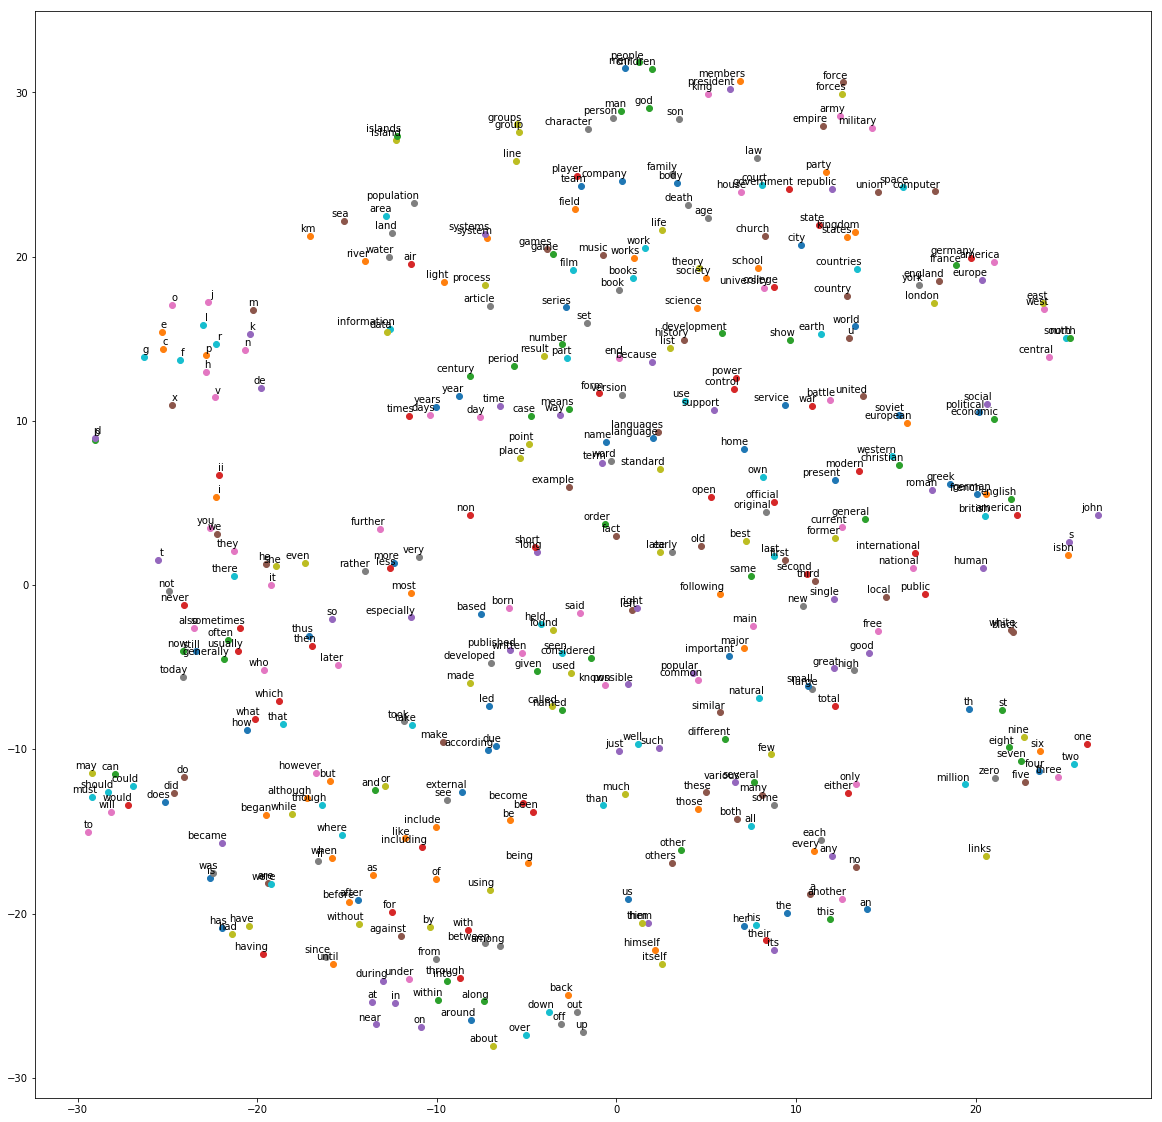

In [10]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(20,20))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)